# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import tensorflow as tf
import json


FIRST_DATA_PATH = 'nn0.txt'
SECOND_DATA_PATH = 'nn1.txt'
FIRST_WEIGHTS_PATH = 'wnet0'
SECOND_WEIGHTS_PATH = 'wnet1'



DEBUG = False
SEARCHING_HYPERPARAMETERS = False

In [2]:
def reset_seed(seed = 420):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [3]:
COL_WIDTHS = [10,10,25]
def get_table_header():
    headers = ["From", "To", "Weight"]
    header = '|'
    for header_text, width in zip(headers, COL_WIDTHS):
        header += ' {} |'.format(str(header_text).ljust(width))
    separator = '+{}+'.format('+'.join('-' * (width + 2) for width in COL_WIDTHS))
    return separator + '\n' + header + '\n' + separator + '\n'

def get_table_row(row):
    table_row = '|'
    for element, width in zip(row, COL_WIDTHS):
        table_row += ' {} |'.format(str(element).ljust(width))
    return table_row

def get_table_footer():
    separator = '+{}+'.format('+'.join('-' * (width + 2) for width in COL_WIDTHS))
    return separator

In [4]:
def load_file_as_numpy(file_path):
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()
    
    # Split each line into features and label
    data = [line.split() for line in lines]

    # Extract features and labels
    features = np.array([list(map(int, line[0])) for line in data])
    labels =  np.array([int(line[1]) for line in data])

    return features, labels

In [5]:
def split_data(x_data, y_data, val_ratio=0.8):
    
    # Randomly shuffle data
    shuffled_indices = np.random.permutation(len(x_data))
    x_data, y_data = x_data[shuffled_indices], y_data[shuffled_indices]

    # Split data into training and testing sets
    train_size = int(len(x_data) * val_ratio)
    x_train, y_train = x_data[:train_size], y_data[:train_size]
    x_val, y_val = x_data[train_size:], y_data[train_size:]

    return x_train, y_train, x_val, y_val

In [6]:
def normalize(x):
    x[x == 0] = -1
    return x

In [7]:
def get_data(file_path):
    x_data, y_data = load_file_as_numpy(file_path)
    x_train, y_train, x_val, y_val = split_data(x_data, y_data)
    x_train = normalize(x_train)
    x_val= normalize(x_val)
    return x_train, y_train, x_val, y_val

In [8]:
def plot_history(history, has_val=True, file_name=None):
    # Plot the fitness alone
    plt.plot(history['fitness'])
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    if file_name is not None:
        plt.savefig(file_name + '_fitness.png')
    plt.show()

    # Plot the accuracies and add legend
    plt.plot(history['accuracy'])
    if has_val:
        plt.plot(history['val_accuracy'])
        plt.legend(['Training accuracy', 'Validation accuracy'])
    else:
        plt.legend(['Training accuracy'])
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    if file_name is not None:
        plt.savefig(file_name + '_accuracy.png')
    plt.show()

 


# Edge

In [9]:
class Edge:
    INPUT_SIZE = 16
    
    INPUT_TO_HIDDEN = 0
    HIDDEN_TO_HIDDEN = 1
    HIDDEN_TO_OUTPUT = 2
    INPUT_TO_OUTPUT = 3
    BIAS_TO_HIDDEN = 4
    BIAS_TO_OUTPUT = 5

    def __init__(self, in_node, out_node, weight, type):
        self.in_node = in_node
        self.out_node = out_node
        self.weight = weight
        self.type = type

    def copy(self):
        return Edge(self.in_node, self.out_node, self.weight, self.type)

    def __str__(self):
        weight_string = str(self.weight)
        
        if self.type in (Edge.INPUT_TO_HIDDEN, Edge.INPUT_TO_OUTPUT):
            in_string = 'INPUT #{}'.format(self.in_node+1)
        elif self.type in (Edge.HIDDEN_TO_HIDDEN, Edge.HIDDEN_TO_OUTPUT):
            in_string = 'Node #{}'.format(self.in_node+1 - Edge.INPUT_SIZE)
        else:
            in_string = 'BIAS'
        
        if self.type in (Edge.HIDDEN_TO_HIDDEN, Edge.INPUT_TO_HIDDEN, Edge.BIAS_TO_HIDDEN):
            out_string = 'Node #{}'.format(self.out_node+1 - Edge.INPUT_SIZE)
        else:
            out_string = 'Output'

        return get_table_row([in_string, out_string, weight_string])

    def __hash__(self):
        return hash((self.in_node, self.out_node, self.type))

    def __eq__(self, other):
        return self.in_node == other.in_node and self.out_node == other.out_node and self.type == other.type

# Genome

In [10]:
class Genome:
    INPUT_NODE_COUNT = 16
    

    OUTPUT_NODE = 999999
    BIAS_NODE = -1
    CALCULATION_ERROR = -float('inf') 

    def __init__(self, chance_to_change_weight = 0.7, chance_to_delete_edge = 0.1, chance_to_add_edge = 0.3, chance_to_add_node = 0.1, chance_to_delete_node = 0.05):
        self.hidden_nodes_count = 0
        self.model = None
        # Create basic edges
        self.edges = []
        for i in range(Genome.INPUT_NODE_COUNT):
                self.edges.append(Edge(i, Genome.OUTPUT_NODE, random.gauss(0, 1), Edge.INPUT_TO_OUTPUT))
        self.edges.append(Edge(Genome.BIAS_NODE, Genome.OUTPUT_NODE, random.gauss(0, 1), Edge.BIAS_TO_OUTPUT))

        # constants
        self.chance_to_change_weight = chance_to_change_weight
        self.chance_to_delete_edge = chance_to_delete_edge
        self.chance_to_add_edge = chance_to_add_edge
        self.chance_to_add_node = chance_to_add_node
        self.chance_to_delete_node = chance_to_delete_node


    def __str__(self):
        # Create a table that describes the model
        output_string = get_table_header()

        sorted_edges = sorted(self.edges, key=lambda edge: (edge.in_node, edge.out_node))
        for edge in sorted_edges:
            output_string += str(edge) + "\n"

        output_string += get_table_footer()
        output_string += "\n\n"
        return output_string
    
    def save_as_json(self, file_path):
        with open(file_path, 'w') as f:
            f.write(str(self.hidden_nodes_count) + "\n")
            for edge in self.edges:
                f.write(json.dumps(edge.__dict__) + "\n")
    
    def load_from_json(self, file_path):
        with open(file_path, 'r') as f:
            self.hidden_nodes_count = int(f.readline())
            self.edges = []
            for line in f:
                if line == "\n":
                    continue
                edge = Edge(**json.loads(line))
                self.edges.append(edge)
    

    
    
    def copy(self):
        new_genome = Genome(chance_to_add_edge=self.chance_to_add_edge,
                             chance_to_add_node=self.chance_to_add_node,
                               chance_to_change_weight=self.chance_to_change_weight,
                                 chance_to_delete_edge=self.chance_to_delete_edge,
                                   chance_to_delete_node=self.chance_to_delete_node)
        new_genome.hidden_nodes_count = self.hidden_nodes_count
        new_genome.edges = []
        for edge in self.edges:
            new_genome.edges.append(edge.copy())
        return new_genome    
            
    def mutate_weights(genome):
        while random.random() < genome.chance_to_change_weight:
            edge = random.choice(genome.edges)
            rnd = random.random()
            if rnd < 0.20:
                edge.weight = random.gauss(0, 1)
            elif rnd < 0.4:
                edge.weight += random.gauss(0, 1)
            elif rnd < 0.6:
                edge.weight *= random.gauss(1, 0.25)  # maybe 0.5?
            elif rnd < 0.8:
                edge.weight *= -1
            else:
                edge.weight = 0

    def mutate_delete_edge(genome):
        if random.random() < genome.chance_to_delete_edge:
            edge = random.choice(genome.edges)
            genome.edges.remove(edge)

    def edge_exists(self, in_node, out_node):
        for edge in self.edges:
            if edge.in_node == in_node and edge.out_node == out_node:
                return True
            if edge.in_node == out_node and edge.out_node == in_node:
                return True
        return False
    
    def mutate_add_edge(genome):
        if random.random() < genome.chance_to_add_edge:
            last_node_index = Genome.INPUT_NODE_COUNT + genome.hidden_nodes_count - 1
            # pick a random input or hidden node or the bias node
            in_node = random.randint(Genome.BIAS_NODE, last_node_index)

            # pick a random output or hidden node
            if random.random() < 1 / (last_node_index+2) or genome.hidden_nodes_count == 0:
                out_node = Genome.OUTPUT_NODE
            else:
                out_node = random.randint(Genome.INPUT_NODE_COUNT, last_node_index)

            # Repick until we get a new edge that doesn't already exist
            tries = 0
            while genome.edge_exists(in_node, out_node) or in_node == out_node:
                tries += 1
                in_node = random.randint(Genome.BIAS_NODE, last_node_index)

                if random.random() < 1 / (last_node_index+2) or genome.hidden_nodes_count == 0:
                    out_node = Genome.OUTPUT_NODE
                else:
                    out_node = random.randint(Genome.INPUT_NODE_COUNT, last_node_index)
                if tries == 20:
                    return

            
            # create the new edge
            if in_node == Genome.BIAS_NODE:
                type = Edge.BIAS_TO_HIDDEN
            elif in_node < Genome.INPUT_NODE_COUNT:
                if out_node <= last_node_index:
                    type = Edge.INPUT_TO_HIDDEN
                else:
                    type = Edge.INPUT_TO_OUTPUT
            else:
                if out_node <= last_node_index:
                    type = Edge.HIDDEN_TO_HIDDEN
                else:
                    type = Edge.HIDDEN_TO_OUTPUT
            new_edge = Edge(in_node, out_node, random.gauss(0, 1), type)

            # add the new edge to the genome
            genome.edges.append(new_edge)

    def mutate_add_node(genome):
        if random.random() < genome.chance_to_add_node:   
            # Pick a random edge
            edge = random.choice(genome.edges)

            if(edge.type == Edge.INPUT_TO_HIDDEN):
                type1=  Edge.INPUT_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_HIDDEN
            elif(edge.type == Edge.INPUT_TO_OUTPUT):
                type1 = Edge.INPUT_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_OUTPUT
            elif(edge.type == Edge.HIDDEN_TO_HIDDEN):
                type1 = Edge.HIDDEN_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_HIDDEN
            elif(edge.type == Edge.HIDDEN_TO_OUTPUT):
                type1 = Edge.HIDDEN_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_OUTPUT
            elif(edge.type == Edge.BIAS_TO_HIDDEN):
                type1 = Edge.BIAS_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_HIDDEN
            else:
                type1 = Edge.BIAS_TO_HIDDEN
                type2 = Edge.HIDDEN_TO_OUTPUT

            # Increase the hidden node count
            genome.hidden_nodes_count += 1
            last_node_index = Genome.INPUT_NODE_COUNT + genome.hidden_nodes_count - 1
            new_node = last_node_index

            # Create two new edges with random weights
            new_edge_1 = Edge(edge.in_node, new_node, random.gauss(0, 1), type1)
            new_edge_2 = Edge(new_node, edge.out_node, random.gauss(0, 1), type2)

            # Add the new edges to the genome

            genome.edges.append(new_edge_1)
            genome.edges.append(new_edge_2)

    def mutate_delete_node(genome):
            last_node_index = Genome.INPUT_NODE_COUNT + genome.hidden_nodes_count - 1
            if random.random() < genome.chance_to_delete_node:
                # leave if there are no hidden nodes
                if genome.hidden_nodes_count == 0:
                    return
                
                # select a random node on the hidden layer
                node = random.randint(Genome.INPUT_NODE_COUNT, last_node_index)

                # remove all edges connected to the node
                genome.edges = [edge for edge in genome.edges if edge.in_node != node and edge.out_node != node]

                # Update edges to support new numbering
                for edge in genome.edges:
                    # if the edge's in node is greater than the node, decrement it
                    if edge.in_node > node and edge.in_node != Genome.OUTPUT_NODE:
                        edge.in_node -= 1
                    # if the edge's out node is greater than the node, decrement it
                    if edge.out_node > node and edge.out_node != Genome.OUTPUT_NODE:
                        edge.out_node -= 1

                # decrement the hidden node count
                genome.hidden_nodes_count -= 1
                
    def mutate(self):
        # make a copy of the genome
        new_genome = self.copy()

        Genome.mutate_weights(new_genome)
        Genome.mutate_delete_edge(new_genome)
        Genome.mutate_add_node(new_genome)
        Genome.mutate_add_edge(new_genome)
        Genome.mutate_delete_node(new_genome)

        return new_genome

    def crossover(gen_A, gen_B):
        # check how many spots are common from the start of edges
        new_edges = []
        new_edges_indexes = []
        uncommon_edges = []
        for i in range(min(len(gen_A.edges), len(gen_B.edges))):
            # if the in and out nodes are the same add it to the common edges
            if gen_A.edges[i].in_node == gen_B.edges[i].in_node and gen_A.edges[i].out_node == gen_B.edges[i].out_node:
                if random.random() < 0.5:
                    new_edges.append(gen_A.edges[i])
                else:
                    new_edges.append(gen_B.edges[i])
                new_edges_indexes.append(i)
            else:
                uncommon_edges.append(gen_A.edges[i])
                uncommon_edges.append(gen_B.edges[i])
        
        # Calculate the chance to add an uncommon edge
        edges_to_add_on_average = (len(gen_A.edges) + len(gen_B.edges)) / 2 - len(new_edges)
        if len(uncommon_edges) > 0:
            if edges_to_add_on_average > 0:
                chance_to_add_edge = edges_to_add_on_average/len(uncommon_edges)
            else:
                chance_to_add_edge = 0

        # Take with 50% chance the rest of the edges and check for duplicates
        for edge in uncommon_edges:
            edge_exists = False
            for new_edge in new_edges:
                if edge.in_node == new_edge.in_node and edge.out_node == new_edge.out_node:
                    edge_exists = True
                    break
            if not edge_exists:
                if random.random() < chance_to_add_edge:
                    new_edges.append(edge)
            



        # Check the max in or out node for the new edges
        max_node = 0
        for edge in new_edges:
            if edge.in_node > max_node and edge.in_node != Genome.OUTPUT_NODE:
                max_node = edge.in_node
            if edge.out_node > max_node and edge.out_node != Genome.OUTPUT_NODE:
                max_node = edge.out_node
        max_node = max(max_node, Genome.INPUT_NODE_COUNT)
        
        # Create the new genome
        new_genome = Genome(chance_to_change_weight=gen_A.chance_to_change_weight,
                                           chance_to_delete_edge=gen_A.chance_to_delete_edge,
                                             chance_to_add_edge=gen_A.chance_to_add_edge,
                                               chance_to_add_node=gen_A.chance_to_add_node,
                                                 chance_to_delete_node=gen_A.chance_to_delete_node)
        new_genome.hidden_nodes_count = max_node - Genome.INPUT_NODE_COUNT + 1
        new_genome.edges = new_edges

        return new_genome
    
    def get_all_reached_nodes(self, edges_coming_from):
        reached_nodes = set(range(Genome.INPUT_NODE_COUNT)).union({Genome.BIAS_NODE})

        index = 0
        while index < len(reached_nodes):
            current_node = list(reached_nodes)[index]
            if current_node != Genome.OUTPUT_NODE:
                for edge in edges_coming_from[current_node]:
                    if edge.out_node not in reached_nodes:
                        reached_nodes.add(edge.out_node)
            index += 1
        return reached_nodes
    
    def remove_all_nodes_not_connected_to_output(self, reached_nodes, edges_coming_to):
        new_reached_nodes = set({Genome.OUTPUT_NODE})
        index = 0
        while index < len(new_reached_nodes):
            current_node = list(new_reached_nodes)[index]
            if current_node != Genome.INPUT_NODE_COUNT:
                for edge in edges_coming_to[current_node]:
                    if (edge.in_node in reached_nodes) and (edge.in_node not in new_reached_nodes):
                        new_reached_nodes.add(edge.in_node)
            index += 1
        return new_reached_nodes
    
    def get_edges_to_and_from(self):
        #print(self.hidden_nodes_count)
        all_node_numbers = set(range(Genome.INPUT_NODE_COUNT + self.hidden_nodes_count)).union({Genome.BIAS_NODE}).union({Genome.OUTPUT_NODE})
        edges_coming_to = {node: [] for node in all_node_numbers}
        edges_coming_from = {node: [] for node in all_node_numbers}
        for edge in self.edges:
            if edge.weight != 0:
                edges_coming_to[edge.out_node].append(edge)
                edges_coming_from[edge.in_node].append(edge)

        return edges_coming_to, edges_coming_from
    
    def feed_forward(self, x):
        if self.model is None:
            self.create_model()
        if self.model is None:
            return np.array([Genome.CALCULATION_ERROR])
        

        # Set the input nodes
        input_values = x
        computed_output = self.model.predict(np.array(input_values), verbose=0)
        return computed_output

    def remove_edges_from_unreached_nodes(edges_coming_to, reached_nodes):
        new_edges_coming_to = {}
        # remove edges from and to unreached nodes
        for node in edges_coming_to:
            new_edges_coming_to[node] = []
            for edge in edges_coming_to[node]:
                if edge.in_node in reached_nodes and edge.out_node in reached_nodes:
                    new_edges_coming_to[node].append(edge)
   

        return new_edges_coming_to

    def create_model(self):
        edges_coming_to, edges_coming_from = self.get_edges_to_and_from()
        reached_nodes_from_input = self.get_all_reached_nodes(edges_coming_from)
        nodes_in_calculation_path = self.remove_all_nodes_not_connected_to_output(reached_nodes_from_input, edges_coming_to)
        edges_coming_to = Genome.remove_edges_from_unreached_nodes(edges_coming_to, nodes_in_calculation_path)

        if Genome.OUTPUT_NODE not in nodes_in_calculation_path:
            self.model = None
            return
        
        nodes_in_calculation_path.remove(Genome.OUTPUT_NODE)
        
        calculated_nodes_indexes = set(range(Genome.INPUT_NODE_COUNT)).union({Genome.BIAS_NODE})

        input_nodes_of = {node: {edge.in_node for edge in edges_coming_to[node]} for node in nodes_in_calculation_path}

        nodes_to_calculate = [node for node in nodes_in_calculation_path if node not in calculated_nodes_indexes]
        order_of_calculation = []
        while len(nodes_to_calculate) > 0:
            has_progress = False
            for node in nodes_to_calculate:
                    if input_nodes_of[node].issubset(calculated_nodes_indexes):
                        calculated_nodes_indexes.add(node)
                        nodes_to_calculate.remove(node)
                        order_of_calculation.append(node)
                        has_progress = True
            if(not has_progress):
                self.model = None
                return
        
        self.create_tf_model_from_calculation_path(order_of_calculation, edges_coming_to)
        
    def create_tf_model_from_calculation_path(self, order_of_calculation, edges_coming_to):
        inputs = tf.keras.Input(shape=(Genome.INPUT_NODE_COUNT,))
        input_saved = []

        for i in range(Genome.INPUT_NODE_COUNT):
            neuron_input = inputs[:, i]
            input_saved.append(tf.identity(neuron_input))

        after_sigmoid_layers = {}

        for node in order_of_calculation:
            layers_to_add = []
            for edge in edges_coming_to[node]:
                if edge.in_node == Genome.BIAS_NODE:
                    layers_to_add.append(tf.constant(edge.weight, dtype=tf.float32, shape=(1,)))
                elif edge.in_node < Genome.INPUT_NODE_COUNT:
                    layers_to_add.append(tf.keras.layers.Multiply()([input_saved[edge.in_node], tf.constant(edge.weight, dtype=tf.float32, shape=(1,))]))
                else:
                    layers_to_add.append(tf.keras.layers.Multiply()([after_sigmoid_layers[edge.in_node - Genome.INPUT_NODE_COUNT], tf.constant(edge.weight, dtype=tf.float32, shape=(1,))]))
            if len(layers_to_add) == 0:
                self.model = None
                return
            after_sigmoid_layers[node - Genome.INPUT_NODE_COUNT] = tf.keras.activations.sigmoid(tf.keras.layers.Add()(layers_to_add))


            
        
        layers_to_add = []
        for edge in edges_coming_to[Genome.OUTPUT_NODE]:
            if edge.in_node == Genome.BIAS_NODE:
                layers_to_add.append(tf.constant(edge.weight, dtype=tf.float32, shape=(1,)))
            elif edge.in_node < Genome.INPUT_NODE_COUNT:
                layers_to_add.append(tf.keras.layers.Multiply()([input_saved[edge.in_node], tf.constant(edge.weight, dtype=tf.float32, shape=(1,))]))
            else:
                layers_to_add.append(tf.keras.layers.Multiply()([after_sigmoid_layers[edge.in_node - Genome.INPUT_NODE_COUNT], tf.constant(edge.weight, dtype=tf.float32, shape=(1,))]))

        if len(layers_to_add) == 0:
            self.model = None
            return
        output = tf.keras.activations.sigmoid(tf.keras.layers.Add()(layers_to_add))
        
        model = tf.keras.Model(inputs=inputs, outputs=output)

        self.model = model

        
    def calculate_fitness(self,x,y):
        #print(str(self))
        
        pred = self.feed_forward(x)
        if pred.shape != y.shape:
            return Genome.CALCULATION_ERROR, Genome.CALCULATION_ERROR
        pred_thresholded = (pred > 0.5).astype(int)

        # Calculate the accuracy
        accuracy = np.mean(pred_thresholded == y)

        # Reward for being confident, discourage being confident when wrong
        pred_around_zero = pred-0.5 # [-0.5 to 0.5]
        y_plus_minus = y * 2 - 1 # [-1, 1]
        fitness = np.sum(pred_around_zero * y_plus_minus)
        
        return fitness, accuracy 
    
    def predict(self, x):
        pred = self.feed_forward(x)
        pred_thresholded = (pred > 0.5).astype(int)
        return pred_thresholded

# Genetic Algorithm

In [11]:
class GeneticAlgorithm():
    def __init__(self,
                  population_size,
                    x_train, y_train, x_val = None, y_val = None,
                      survivor_count = 1,
                        max_generations=100,
                          chance_to_change_weight = 0.7,
                            chance_to_delete_edge = 0.1,
                              chance_to_add_edge = 0.3,
                                chance_to_add_node = 0.1,
                                  chance_to_delete_node = 0.05):
        self.population_size = population_size
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.survivor_count = survivor_count
        self.max_generations = max_generations
        self.population = []
        self.fitnesses = []
        self.best_genome = None
        self.best_accuracy =0
        self.best_genome_val_accuracy = Genome.CALCULATION_ERROR
        self.best_fitness = - float('inf')
        self.generation = 0
        self.is_new_best = False
        self.starting_time = 0
        self.history = {}

        self.chance_to_change_weight = chance_to_change_weight
        self.chance_to_delete_edge = chance_to_delete_edge
        self.chance_to_add_edge = chance_to_add_edge
        self.chance_to_add_node = chance_to_add_node
        self.chance_to_delete_node = chance_to_delete_node

    
    def initiate_population(self):
        for i in range(self.population_size):
            self.population.append(Genome(chance_to_change_weight=self.chance_to_change_weight,
                                           chance_to_delete_edge=self.chance_to_delete_edge,
                                             chance_to_add_edge=self.chance_to_add_edge,
                                               chance_to_add_node=self.chance_to_add_node,
                                                 chance_to_delete_node=self.chance_to_delete_node))

    def calculate_fitnesses_and_accuracy(self):
        self.fitnesses = []
        
        for genome in self.population:
            if (DEBUG):
                print(str(genome))
            fitness, accuracy =  genome.calculate_fitness(self.x_train, self.y_train) 
            self.fitnesses.append(fitness)

            if fitness > self.best_fitness:
                self.best_fitness = fitness
                self.best_accuracy = accuracy
                self.best_genome = genome
                if self.x_val is not None:
                    self.best_genome_val_accuracy = genome.calculate_fitness(self.x_val, self.y_val)[1]
                self.is_new_best = True
        # update history
        self.history['generation'].append(self.generation)
        self.history['fitness'].append(self.best_fitness)
        self.history['accuracy'].append(self.best_accuracy)
        if self.x_val is not None:
            self.history['val_accuracy'].append(self.best_genome_val_accuracy)
        
            

    def select_survivors(self):

        # Create a list of tuples pairing individuals with their fitness values
        population_with_fitness = list(zip(self.population, self.fitnesses))
    

        # Sort the population_with_fitness list based on fitness values in descending order
        sorted_population = sorted(population_with_fitness, key=lambda x: x[1], reverse=True)

        # Extract the sorted individuals from the sorted_population list
        self.population = [x[0] for x in sorted_population]
        self.fitnesses = [x[1] for x in sorted_population]
        # Select the survivors
        self.population = self.population[:self.survivor_count]
        self.fitnesses = self.fitnesses[:self.survivor_count]


    def repopulate(self):
        # Create the new population
        new_population = []
        # Add the last population to the new population
        new_population.extend(self.population)
        
        # Create the new population by crossover
        while len(new_population) < self.population_size:
            # Select 2 random genomes
            genome_A = random.choice(self.population)
            genome_B = random.choice(self.population)

            # Crossover and mutate the genomes
            new_genome = Genome.crossover(genome_A, genome_B).mutate()

            # Add the new genome to the new population
            new_population.append(new_genome)
        # Replace the old population with the new one
        self.population = new_population

    
    def print_generation(self):
            # TEMPORARY
            from IPython.display import clear_output
            TEST = True

            time_passed = time.time() - self.starting_time

            # Convert time_passed to hours, minutes, and seconds
            hours, remainder = divmod(time_passed, 3600)
            minutes, seconds = divmod(remainder, 60)

            # Create a string representation
            time_string = ""
            if hours > 0:
                time_string += f"{int(hours)}h"
            if minutes > 0:
                time_string += f"{int(minutes)}m"
            time_string += f"{int(seconds)}s"
            clear_output(wait=True)
            print("Generation: ", self.generation+1, "Time passed: ", time_string)
            if TEST:
                if self.is_new_best:
                    print("New best genome found!")
                    self.is_new_best = False
                else:
                    print("Best genome from previous generations")
                print("Fitness ", self.best_fitness)
                print("Accuracy ", self.best_accuracy)
                if self.x_val is not None:
                    print("Validation accuracy ", self.best_genome_val_accuracy)
                print(self.best_genome)
            else:
                if self.is_new_best:
                    print("New best genome found!")
                    print("Fitness ", self.best_fitness)
                    print("Accuracy ", self.best_accuracy)
                    if self.x_val is not None:
                        print("Validation accuracy ", self.best_genome_val_accuracy)
                    print(self.best_genome)
                    self.is_new_best = False

    def run(self):
        if self.x_val is not None:
            self.history = {'fitness':[], 'accuracy':[], 'val_accuracy':[], 'generation':[]}
        else:
            self.history = {'fitness':[], 'accuracy':[], 'generation':[]}
        
        self.starting_time = time.time()
        self.initiate_population()
        self.calculate_fitnesses_and_accuracy()
        while self.generation < self.max_generations and (self.best_accuracy < 1.0 or self.best_genome_val_accuracy < 1.0):
            self.print_generation()
            self.generation += 1
            self.select_survivors()
            self.repopulate()
            self.calculate_fitnesses_and_accuracy()
        self.print_generation()

            

        return self.best_genome, self.history

    def predict(self, x):
        return self.best_genome.predict(x)
    
    def get_model(self):
        return self.best_genome.model

            


# Search For Best Hyper-Parameters

## Original Parameters

### First Data Set

In [12]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337420)
  x_train, y_train, x_val, y_val = get_data(FIRST_DATA_PATH)

  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=20,
                                  survivor_count=4,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05) # should be 200 generations
  best_genome, history = algorithm.run()

In [13]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='original_1')

In [14]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='model.png', show_layer_names=False)

### Second Data Set

In [15]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(420)
  x_train, y_train, x_val, y_val = get_data(SECOND_DATA_PATH)



  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=20,
                                  survivor_count=4,
                                    max_generations=400,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05) # should be 400 generations
  best_genome, history = algorithm.run()

In [16]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='original_2')

In [17]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='model2.png', show_layer_names=False)

## Population Size Increase

### First Data Set

In [18]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(FIRST_DATA_PATH)



  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=40,
                                  survivor_count=8,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05)

  best_genome, history = algorithm.run()

In [19]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='bigger_pop_1')

In [20]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='bigger_population_model.png', show_layer_names=False)

### Second Data Set

In [21]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(SECOND_DATA_PATH)



  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=40,
                                  survivor_count=8,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05)

  best_genome, history = algorithm.run()


In [22]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='bigger_pop_2')

In [23]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='bigger_population_model2.png', show_layer_names=False)

## More survivors

### First Data Set

In [24]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(FIRST_DATA_PATH)



  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=40,
                                  survivor_count=16,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05)

  best_genome, history = algorithm.run()

In [25]:
if SEARCHING_HYPERPARAMETERS:  
    plot_history(history, has_val=True, file_name='more_survivors_1')

In [26]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='more_survivors_model.png', show_layer_names=False)

### Second Data Set

In [27]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(SECOND_DATA_PATH)



  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=40,
                                  survivor_count=16,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.8,
                                            chance_to_add_node = 0.9,
                                              chance_to_delete_node = 0.05)

  best_genome, history = algorithm.run()

In [28]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='more_survivors_2')

In [29]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='more_survivors_model2.png', show_layer_names=False)

## Lower Mutation Rates

### First Data Set

In [30]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(FIRST_DATA_PATH)

  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=20,
                                  survivor_count=4,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.4,
                                            chance_to_add_node = 0.2,
                                              chance_to_delete_node = 0.05) # should be 200 generations
  best_genome, history = algorithm.run()

In [31]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='less_mutations_1')  

In [32]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='lower_mutation_rate_model.png', show_layer_names=False)

### Second Data Set

In [33]:
if SEARCHING_HYPERPARAMETERS:
  reset_seed(seed=1337)
  x_train, y_train, x_val, y_val = get_data(SECOND_DATA_PATH)

  # Run it on the data
  algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                                population_size=20,
                                  survivor_count=4,
                                    max_generations=200,
                                      chance_to_change_weight = 0.7,
                                        chance_to_delete_edge = 0.1,
                                          chance_to_add_edge = 0.4,
                                            chance_to_add_node = 0.2,
                                              chance_to_delete_node = 0.05) # should be 200 generations
  best_genome, history = algorithm.run()

In [34]:
if SEARCHING_HYPERPARAMETERS:
    plot_history(history, has_val=True, file_name='less_mutations_2')

In [35]:
if SEARCHING_HYPERPARAMETERS:
    tf.keras.utils.plot_model(best_genome.model, to_file='lower_mutation_rate_model2.png', show_layer_names=False)

# Final Model

## First Data Set

In [36]:
reset_seed(seed=1337)
x_train, y_train, x_val, y_val = get_data(FIRST_DATA_PATH)

# Run it on the data
algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                              population_size=30,
                                survivor_count=12,
                                  max_generations=1200,
                                    chance_to_change_weight = 0.7,
                                      chance_to_delete_edge = 0.1,
                                        chance_to_add_edge = 0.9,
                                          chance_to_add_node = 0.1,
                                            chance_to_delete_node = 0.05) # should be 200 generations
best_genome, history = algorithm.run()
best_genome.save_as_json(FIRST_WEIGHTS_PATH)

Generation:  1201 Time passed:  7h38m49s
Best genome from previous generations
Fitness  7520.045308798552
Accuracy  0.9890625
Validation accuracy  0.98975
+------------+------------+---------------------------+
| From       | To         | Weight                    |
+------------+------------+---------------------------+
| BIAS       | Node #2    | 0.21145810587909752       |
| BIAS       | Output     | 0.5784600015788736        |
| INPUT #1   | Node #1    | 1.0208069243353703        |
| INPUT #1   | Node #2    | 0.9919066874885082        |
| INPUT #1   | Node #3    | 0.44330667758037096       |
| INPUT #1   | Node #4    | 0.7628738034921186        |
| INPUT #1   | Node #5    | -0.15146299724995307      |
| INPUT #1   | Node #6    | 1.3772442846045079        |
| INPUT #1   | Node #7    | -1.7027162170871393       |
| INPUT #1   | Output     | 1.772227440572949         |
| INPUT #2   | Node #1    | 2.431409242127392         |
| INPUT #2   | Node #2    | 1.4903098024019092        |
| INP

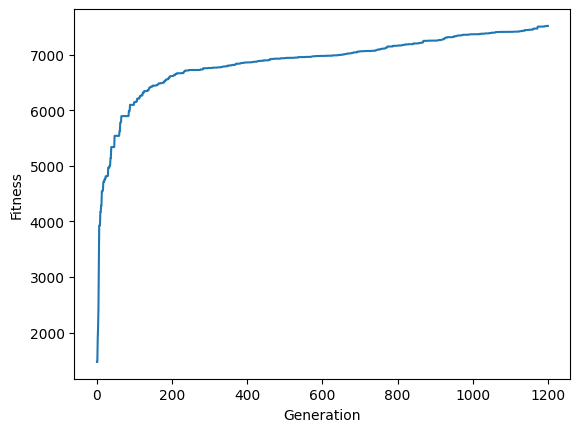

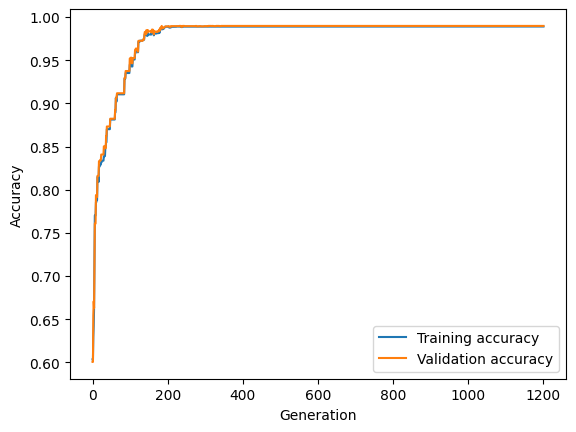

In [37]:
plot_history(history, has_val=True, file_name='final_1')

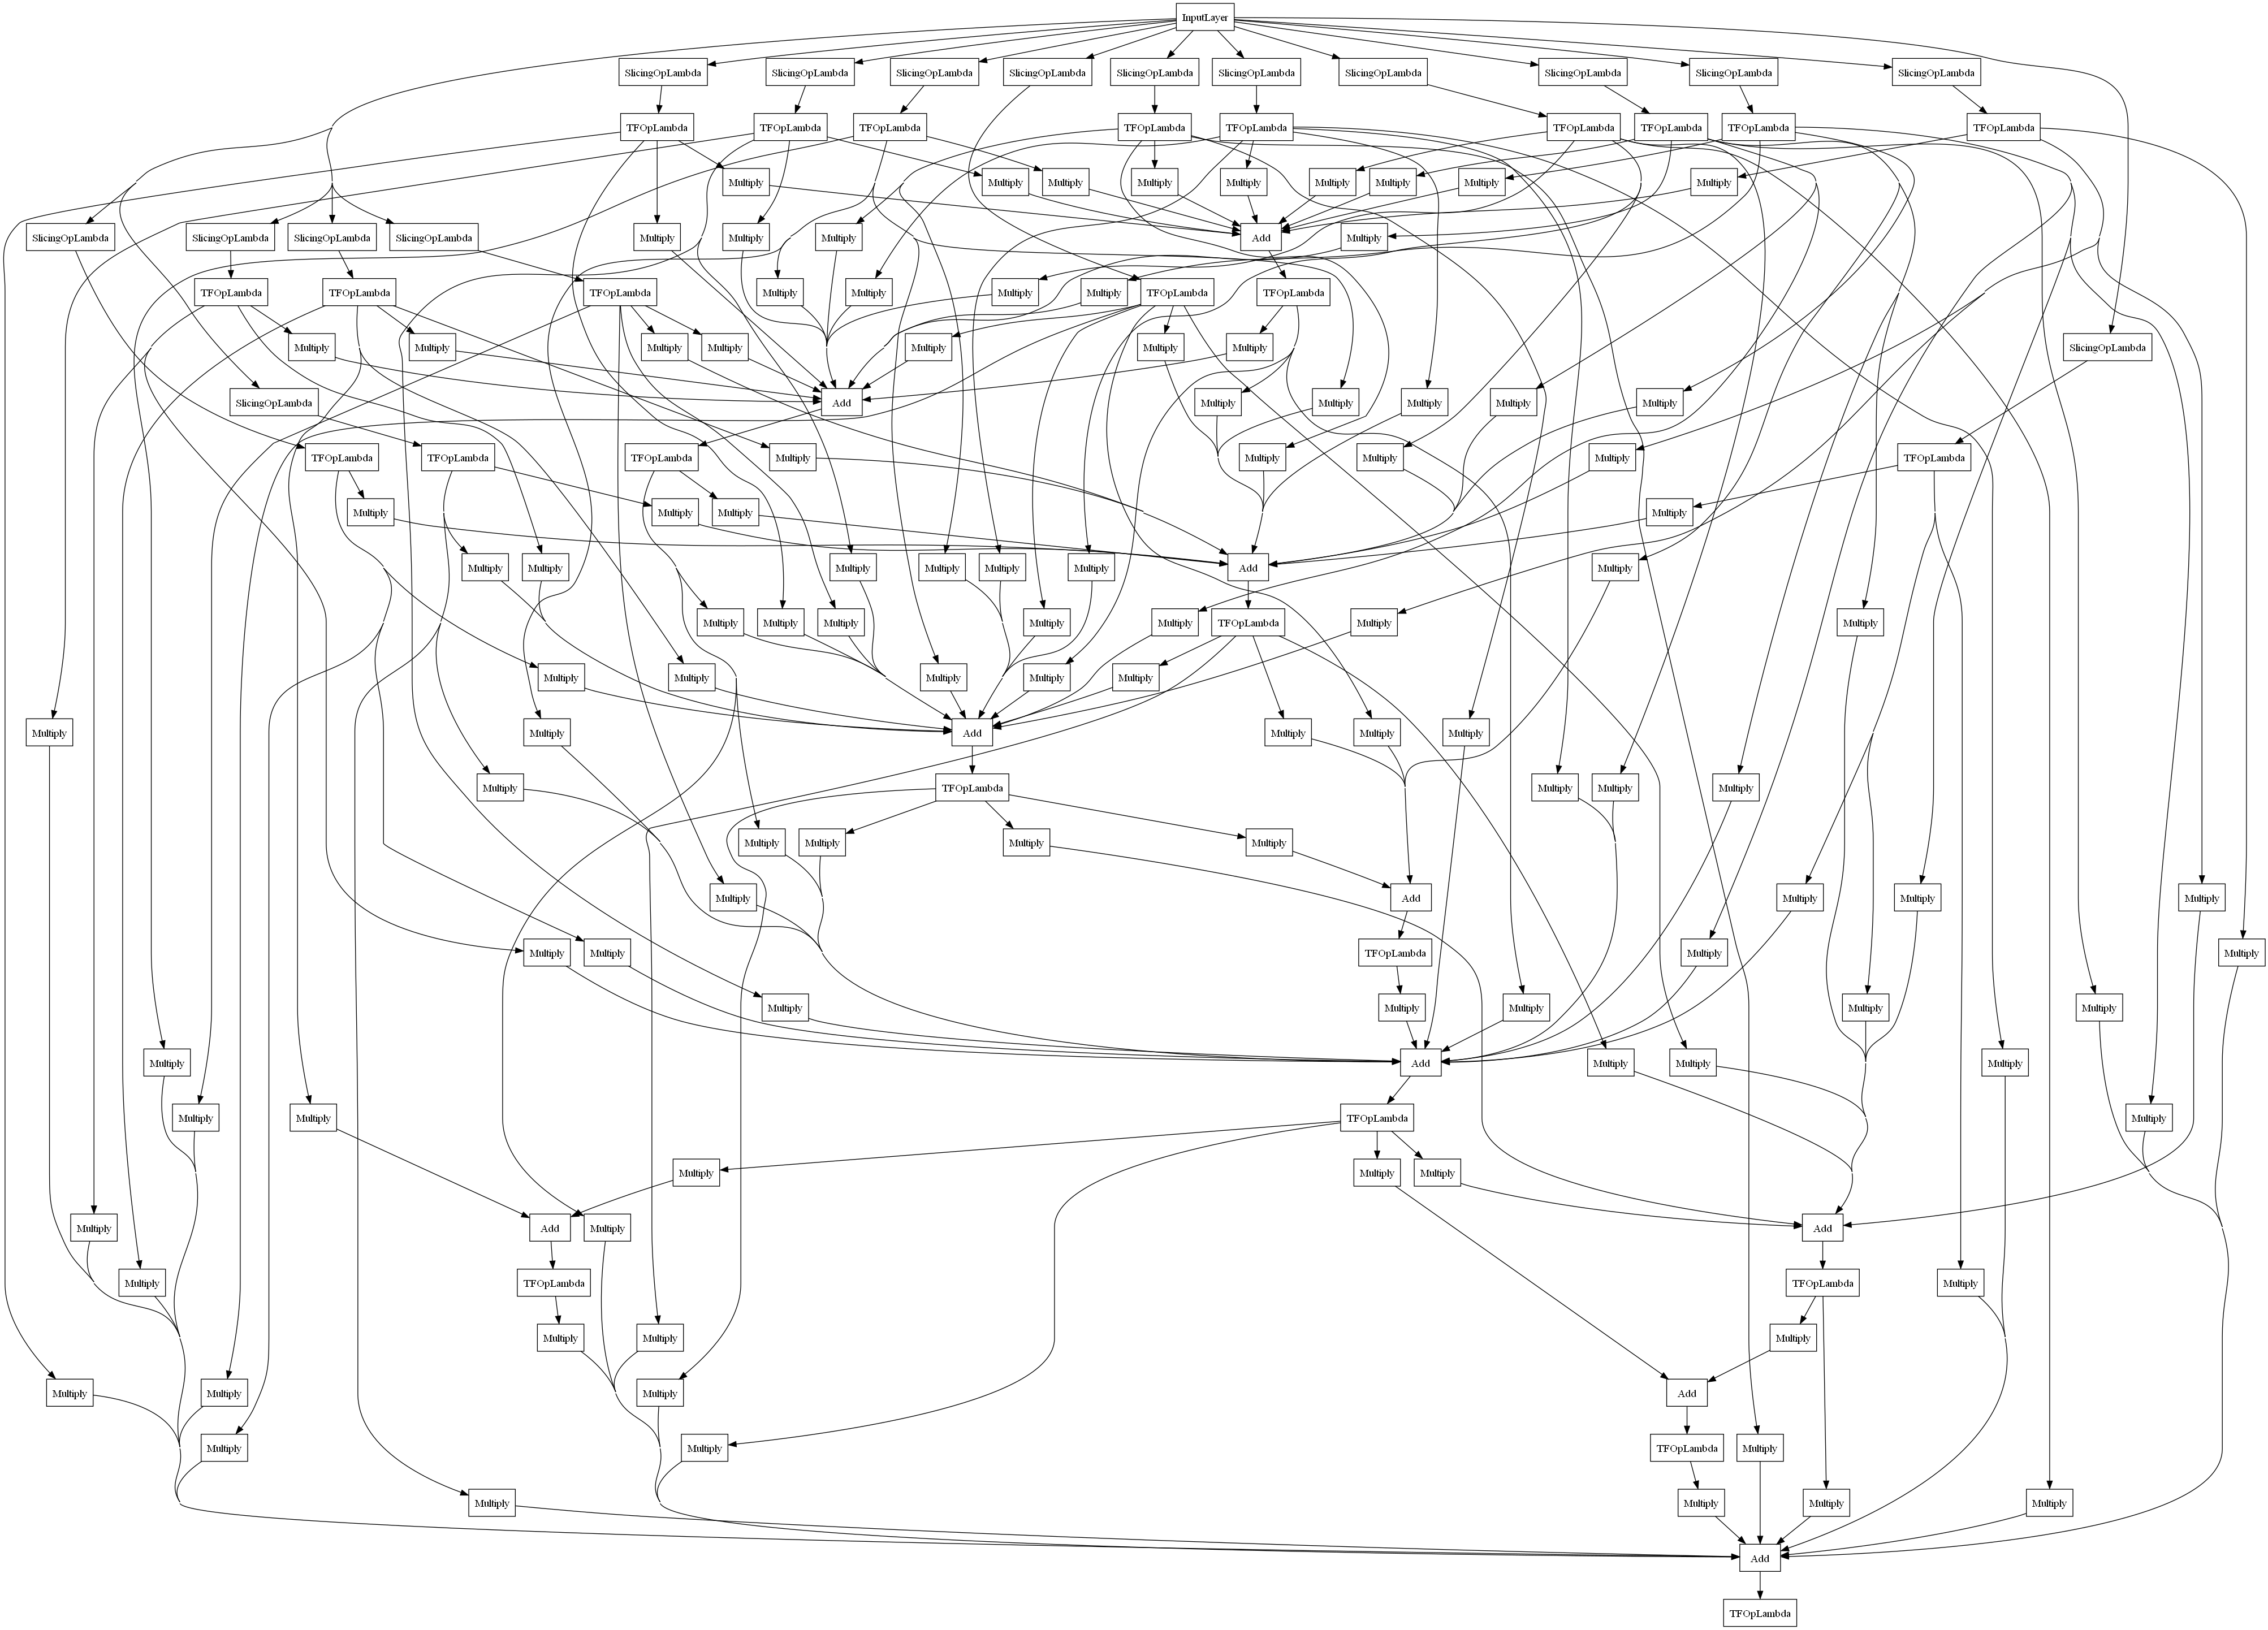

In [38]:
tf.keras.utils.plot_model(best_genome.model, to_file='model_final.png', show_layer_names=False)

## Second Data Set

In [37]:
reset_seed(seed=1337)
x_train, y_train, x_val, y_val = get_data(SECOND_DATA_PATH)

algorithm = GeneticAlgorithm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val,
                            population_size=20,
                                survivor_count=4,
                                max_generations=200,
                                    chance_to_change_weight = 0.7,
                                    chance_to_delete_edge = 0.1,
                                        chance_to_add_edge = 0.4,
                                        chance_to_add_node = 0.2,
                                            chance_to_delete_node = 0.05)


best_genome, history = algorithm.run()
best_genome.save_as_json(SECOND_WEIGHTS_PATH)

Generation:  125 Time passed:  27m5s
New best genome found!
Fitness  7044.066800147295
Accuracy  1.0
Validation accuracy  1.0
+------------+------------+---------------------------+
| From       | To         | Weight                    |
+------------+------------+---------------------------+
| BIAS       | Node #4    | 0.4673095893479505        |
| BIAS       | Node #9    | -0.9760990248405651       |
| BIAS       | Output     | -1.565777110720143        |
| INPUT #1   | Node #3    | 0.07607568277927831       |
| INPUT #1   | Output     | -1.7725897748695367       |
| INPUT #2   | Node #1    | -0.7956332248362601       |
| INPUT #2   | Node #6    | -0.4491828314090346       |
| INPUT #2   | Output     | -1.5300268903215852       |
| INPUT #3   | Output     | -1.800988944050156        |
| INPUT #4   | Node #4    | 0.5998472779009835        |
| INPUT #4   | Node #11   | 0.2096006428151813        |
| INPUT #4   | Output     | -1.508235489745303        |
| INPUT #5   | Node #2    | 0.4789

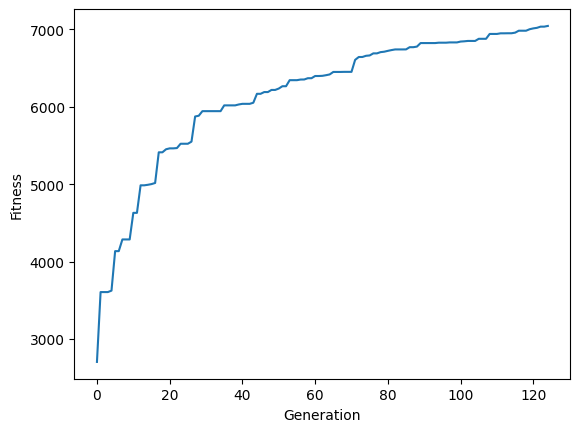

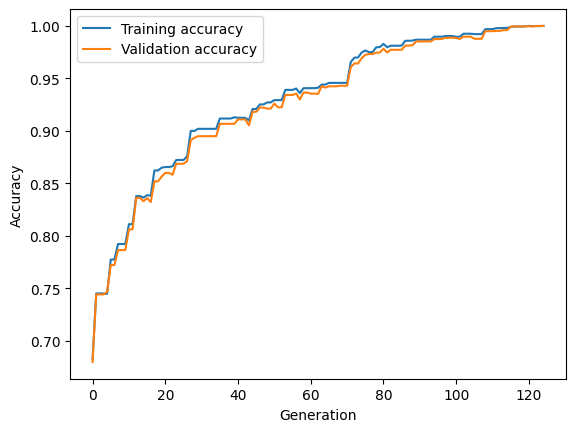

In [38]:
plot_history(history, has_val=True, file_name='final_2')

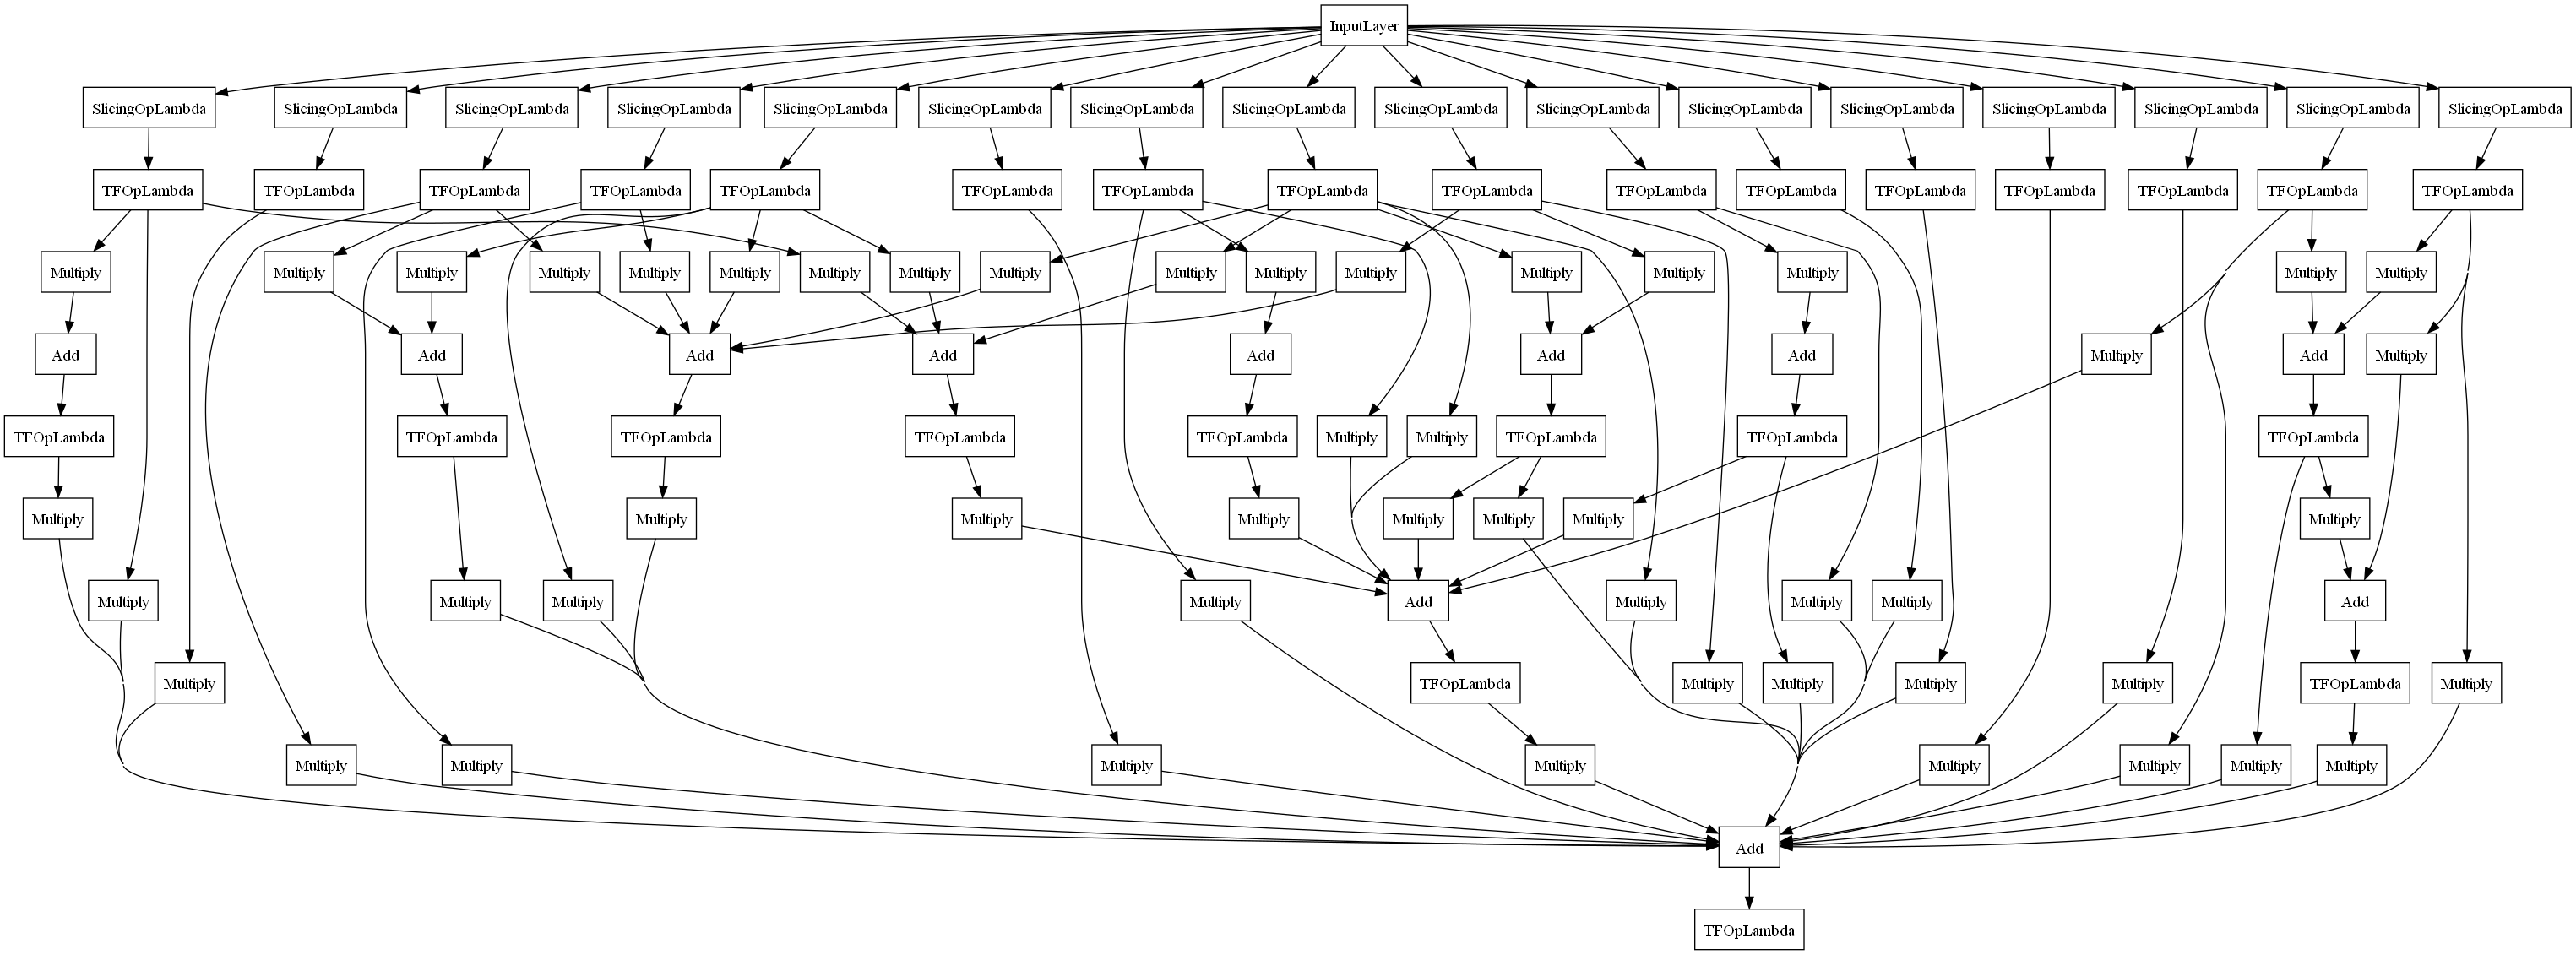

In [39]:
tf.keras.utils.plot_model(best_genome.model, to_file='model_final2.png', show_layer_names=False)